# ***Generative Models***
Remoção *Watermark*

## **Introdução**

O objetivo deste Trabalho Prático Individual passa por fazer uso de *Autoencoders* ou GANs na resolução de um problema em concreto. 

<br/>

**Dessa forma, e para ajudar a criar uma ideia inicial de ambos os modelos e dos seus possíveis *use cases*, atente-se na diferença entre estes *Generative Models:***


1.   ***Autoencoders*** - o seu trabalho passa por aprender de forma simultânea uma *Encoding Network* e uma *Decoding Network*. A ideia passa por fornecer um *input* ao *Encoder*, que tenta então reduzir esta entrada para algo fortemente codificado, de modo a ser depois atribuído ao *Decoder* que trata de reconstruir este *input* codificado.


2.   ***Generative Adversarial Networks*** - o seu trabalho passa por estabelecer um trabalho entre um *Generator* - que através de algum sinal de ruído criar a ideia de *samples* falsos - e um *Discriminator* que tenta então distinguir quais são os *samples* reais perante a falsidade também fornecida pelo *Generator*, criando-se assim um  *adversarial feedback loop*.

<br/>

**Conclusões:**

- O processo de um *Autoencoder* melhora a cada iteração, na medida em que o *Encoder* se torna mais perspicaz a encontrar uma forma compactada/codificada do *input* que recebe e por consequência o *Decoder* torna-se melhor e mais poderoso na reconstrução deste *input* codificado na possível imagem real/original
  - O *Autoencoder* aprende a representar as informações de entrada com muita eficiência
- Uma GAN usa então o tal *loop* para aprender como criar informações que pareçam reais face ao original
- Ambos os modelos possuem bons resultados e o seu uso pode variar dependendo do *Use Case* que se decide estudar

<br/>

**Com tudo isto em mente, e de forma a criar um Projeto nativo e diferente dos tantos existentes, a ideia passará por usar os *Autoencoders* de modo a conseguir remover a *watermark* de uma imagem, tendo como base a arquitetura de um *Convolutional Autoencoder* abaixo representada.**

![Arquitetura Convolutional Autoencoder](https://i.ibb.co/bbTNDVT/Arquitetura-Autoencoder.png)


## **Implementação**

### *Imports*

In [ ]:
# Imports do Python
import os
import string
import random

# Biblioteca Shutil usado para criar/copiar Pastas/Ficheiros
import shutil

# Import do Numpy
import numpy as np

# Import para fazer o Plot das Imagens
import matplotlib.pyplot as plt

# Biblioteca PIL usada para Ler/Manipular as Imagens
from PIL import Image, ImageFont, ImageDraw, ImageOps

# Biblioteca Keras Image para Carregar/Converter as Imagens
from keras.preprocessing.image import load_img, img_to_array

# Biblioteca usada para fazer o Split do Dataset de Treino
from sklearn.model_selection import train_test_split

# Imports usados para o Autoencoder
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, UpSampling2D, Dropout, Add, MaxPool2D
from keras.callbacks import EarlyStopping, History
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


### Variáveis Globais

In [ ]:
# Valores da Largura e Comprimento das Imagens
IMG_WIDTH = 252
IMG_HEIGHT = 252

# Número de Canais das Imagens
# 3 Canais dado que serão Imagens no RGB Color Model
IMG_CHANNELS = 3

# Paths das Pastas de Treino das Imagens com e sem Watermark
PATH_TRAIN_ORIGINAL = '/content/drive/My Drive/Colab Notebooks/dataset/train/original/'
PATH_TRAIN_WATERMARK = '/content/drive/My Drive/Colab Notebooks/dataset/train/watermark/'
PATH_TRAIN_TEST = '/content/drive/My Drive/Colab Notebooks/dataset/test/'

### Funções Auxiliares

In [ ]:
# Função que copia todas as Imagens de uma Sub Pasta para a Pasta de Treino das Imagens Originais
def copy_images_train_without_watermark(list_images, directory_main_folder, directory_sub_folder):

  name_folder = directory_main_folder + directory_sub_folder + '/'
  new_name_folder = '/content/drive/My Drive/Colab Notebooks/dataset/train/original'
  
  for index, name_image in enumerate(list_images):
    shutil.copy(name_folder + name_image, new_name_folder)

# Função que manipula as Imagens Originais e copia todas essas Imagens para a Pasta de Treino das Imagens com Watermark
def copy_images_train_with_watermark(list_images, directory_main_folder, directory_sub_folder, random_values = None):

  name_folder = directory_main_folder + directory_sub_folder + '/'
  new_name_folder = '/content/drive/My Drive/Colab Notebooks/dataset/train/watermark/'

  for name_image in list_images:

    # Abrir a Imagem
    new_image = Image.open(name_folder + name_image)

    # Criação da Fonte a usar na Imagem e o seu Tamanho
    if(random_values != None):
      font = ImageFont.truetype('/content/drive/My Drive/Colab Notebooks/Roboto-Bold.ttf', np.random.randint(low=10, high=50)) 
    else:
      font = ImageFont.truetype('/content/drive/My Drive/Colab Notebooks/Roboto-Bold.ttf', 30) 

    # Criação de uma Imagem Auxiliar/Temporária
    # Servirá para a criação do Texto em si
    # Modo da Imagem 'L' (Pixeis de 1 Bit, Preto e Branco, 1 Pixel por Byte)
    aux_image = Image.new('L', (IMG_WIDTH, IMG_HEIGHT))

    # Criação do Texto a usar como Watermark
    if(random_values != None):
      # O método string.printable retorna todos os Sets de Pontuação, Dígitos, Letras ASCII e Espaço
      # Apanha-se apenas as Letras e Dígitos
      watermark_text = np.random.choice(list(string.printable)[0:61], np.random.randint(low=10, high=15))
      watermark_text = "".join(watermark_text)   
    else:
      watermark_text = 'PROJETO TA'

    # Criação do Desenho
    # Inserção do Texto na tal Imagem Auxiliar/Temporária
    aux_draw = ImageDraw.Draw(aux_image) 
    aux_draw.text((0, 0), watermark_text, font=font, fill=90)

    # Rotação da Watermark na tal Imagem Auxiliar/Temporária
    # Valores Aleatórios para a Rotação
    random_rotation = np.random.randint(low = 0, high = 30)
    rotated_text = aux_image.rotate(random_rotation, expand = 1)

    # Definição da Localização desse Desenho na Foto Original
    # Merge do Desenho com a Imagem Original
    # Salva-se essa Nova Imagem para a Pasta Ideal
    random_location = tuple(np.random.randint(low = 10, high = 100, size = (2,)))
    new_image.paste(ImageOps.colorize(rotated_text, (255, 255, 255), (255, 255, 255)), random_location,  rotated_text)
    new_image.save((new_name_folder + name_image))

# Função que copia todas as Imagens de uma lista para a Pasta de Teste
def copy_images_dataset_test(list_images):

  # Verificar se a Pasta existe e eliminar conteúdo
  # Assim não se repetem Imagens para o Teste
  if not os.path.exists(PATH_TRAIN_TEST):
      os.mkdir(PATH_TRAIN_TEST)
  else:
      shutil.rmtree(PATH_TRAIN_TEST, ignore_errors = True)
      os.mkdir(PATH_TRAIN_TEST)

  # Depois disso, salva as Imagens na Pasta
  for index, name_image in enumerate(list_images):
    shutil.copy(PATH_TRAIN_WATERMARK + name_image, PATH_TRAIN_TEST)

### Pré Processamento dos Dados

#### Criação da Pasta para o *Dataset* de Treino e Teste

In [ ]:
# Função que cria a Pasta de Treino (Original e Watermark) e Teste
def create_folder_train_test():
  
  print('#1 Criar Pastas de Treino "train/original", "train/watermark" e "test"')

  dataset_home = '/content/drive/My Drive/Colab Notebooks/dataset/train/'
  directory_train_original = dataset_home + 'original/'
  directory_train_watermark = dataset_home + 'watermark/'
  directory_test = dataset_home + 'test/'

  # Pasta Treino Original
  if not os.path.exists(directory_train_original):
      os.mkdir(directory_train_original)
  else:
      print('Pasta "original" já existe. A eliminar a pasta...')
      shutil.rmtree(directory_train_original, ignore_errors = True)
      os.mkdir(directory_train_original)

  # Pasta Treino Watermark
  if not os.path.exists(directory_train_watermark):
      os.mkdir(directory_train_watermark)
  else:
      print('Pasta "watermark" já existe. A eliminar a pasta...')
      shutil.rmtree(directory_train_watermark, ignore_errors = True)
      os.mkdir(directory_train_watermark)

  # Pasta Teste
  if not os.path.exists(directory_test):
      os.mkdir(directory_test)
  else:
      print('Pasta "test" já existe. A eliminar a pasta...')
      shutil.rmtree(directory_test, ignore_errors = True)
      os.mkdir(directory_test)

#### Leitura de todas as Imagens e Implementação da *Watermark*

In [ ]:
# Função que copia as Imagens necessárias para a Pasta de Treino (Original e Watermark)
def fill_folder_train(size_dataset, name_sub_folder = None, random_values = None):

  print('\n#2 Copiar as Imagens para as Pastas de Treino "train/original" e "train/watermark"')

  # Diretoria da Pasta Principal do Dataset
  # Diretorias das Sub Pastas do Dataset
  directory_main_folder = '/content/drive/My Drive/Colab Notebooks/dataset/natural_images/'
  directory_sub_folders = os.listdir(directory_main_folder)

  # Inicializar o Número Total de Imagens a 0
  total_images_initial = 0
  total_images_train = 0

  if(name_sub_folder == None):
    # Paths de todas as Imagens contidas em cada Sub Pasta
    for name_path in directory_sub_folders:
        print('Sub Pasta: ' + name_path)

        # Lista com todas as Imagens da Sub Pasta
        images_sub_folder = os.listdir(directory_main_folder + name_path)

        # Escolha aleatória de apenas size_dataset% dessas Imagens
        new_images_sub_folder = random.sample(images_sub_folder, int(round(size_dataset*len(images_sub_folder))))
        # Cópia dessas Imagens para a Pasta de Treino das Imagens Originais
        copy_images_train_without_watermark(new_images_sub_folder, directory_main_folder, name_path)
        # Manipulação das Imagens Originais e Cópia dessas Imagens para a Pasta de Treino das Imagens com Watermark
        if(random_values == None):
          copy_images_train_with_watermark(new_images_sub_folder, directory_main_folder, name_path)
        else:
          copy_images_train_with_watermark(new_images_sub_folder, directory_main_folder, name_path, random_values)
        
        print('Número Images Total em ' + name_path + ': ', len(images_sub_folder))
        print('Número Images Selecionadas de ' + name_path + ': ', len(new_images_sub_folder))
        print('\n')
      
        total_images_initial = len(images_sub_folder)
        total_images_train = len(new_images_sub_folder)
  else:
    if(name_sub_folder == 'person'):
        print('Sub Pasta: ' + name_sub_folder)

        # Lista com todas as Imagens da Sub Pasta
        images_sub_folder = os.listdir(directory_main_folder + name_sub_folder)

        # Escolha aleatória de apenas size_dataset% dessas Imagens
        new_images_sub_folder = random.sample(images_sub_folder, int(round(size_dataset*len(images_sub_folder))))
        # Cópia dessas Imagens para a Pasta de Treino das Imagens Originais
        copy_images_train_without_watermark(new_images_sub_folder, directory_main_folder, name_sub_folder)
        # Manipulação das Imagens Originais e Cópia dessas Imagens para a Pasta de Treino das Imagens com Watermark
        if(random_values == None):
          copy_images_train_with_watermark(new_images_sub_folder, directory_main_folder, name_sub_folder)
        else:
          copy_images_train_with_watermark(new_images_sub_folder, directory_main_folder, name_sub_folder, random_values)

        print('Número Images Total em ' + name_sub_folder + ': ', len(images_sub_folder))
        print('Número Images Selecionadas de ' + name_sub_folder + ': ', len(new_images_sub_folder))
        print('\n')
      
        total_images_initial = len(images_sub_folder)
        total_images_train = len(new_images_sub_folder)

  print('Numero de Imagens Total do Dataset Inicial:', total_images_initial)
  print('Numero de Imagens Total do Dataset Selecionado:', total_images_train)

#### Exemplos de Imagens

In [ ]:
# Função que faz Plot de 5 Imagens Aleatórias
def images_samples():

  print('\n#3 Samples de Imagens Aleatórias (Original/Watermark)')

  # Paths das Diretorias das Imagens Originais e com Watermark
  directory_original = PATH_TRAIN_ORIGINAL
  directory_watermark = PATH_TRAIN_WATERMARK

  # Obter Nomes de Imagens de forma aleatória
  names_photos = sorted(os.listdir(directory_original))
  random_names_photos = random.choices(names_photos, k = 5)

  # Criar um array para o Path dessas Imagens
  # Paths tanto da versão Original como versão Watermark
  selected_photos = []

  for index, name_photo in enumerate(random_names_photos):
      selected_photos.append(directory_original + name_photo)

  for index, name_photo in enumerate(random_names_photos):
      selected_photos.append(directory_watermark + name_photo)

  # Exibir essas Imagens
  figure, ax = plt.subplots(2, 5, figsize=(10,5))
  for i, image_path in enumerate(selected_photos):
      image = Image.open(image_path)
      ax[i//5, i%5].imshow(image)
      ax[i//5, i%5].axis('off')
  plt.show()   

### Criação/Divisão dos vários *Datasets*

#### Leitura/Criação dos *Numpy Arrays* de Imagens

In [ ]:
# Função que cria os Numpy Arrays do Dataset de Treino
def image_numpy_array():

  print('\n#4 Criar Numpy Arrays das Imagens em "train/original" e "train/watermark"')

  # Paths das Imagens de Treino (sem e com Watermark) e Teste
  original_images = os.listdir(PATH_TRAIN_ORIGINAL)
  print(original_images)
  print('Número de Imagens de Treino Originais: ', len(original_images))
  watermark_images = os.listdir(PATH_TRAIN_WATERMARK)
  print('Número de Imagens de Treino com Watermark: ', len(watermark_images))
  test_images = os.listdir(PATH_TRAIN_TEST)
  print('Número de Imagens de Teste: ', len(test_images))

  # Inicialização dos Arrays de Treino
  watermark_train = []
  original_train = []

  for img in watermark_images:
      img = load_img(PATH_TRAIN_WATERMARK + img, target_size=(252,252))
      img = img_to_array(img).astype('float32')/255.
      watermark_train.append(img)

  for img in original_images:
      img = load_img(PATH_TRAIN_ORIGINAL + img, target_size=(252,252))
      img = img_to_array(img).astype('float32')/255.
      original_train.append(img)

  return np.array(watermark_train), np.array(original_train)

#### *Split* do Dataset de Treino em Treino e Validação

In [ ]:
# Função que divide o Dataset de Treino
def split_dataset(watermark_train, original_train):

  print('\n#5 Split do Dataset de Treino em Treino e Validação')

  train_watermark, validation_watermark, train_original, validation_original = train_test_split(watermark_train, original_train, test_size=0.2, random_state=111)
  print("Shape do Dataset de Treino: ", train_watermark.shape)
  print("Shape do Dataset de Validação: ", validation_watermark.shape)
  
  return train_watermark, validation_watermark, train_original, validation_original

### Definição do *Autoencoder*

#### Arquitetura do *Autoencoder*

In [ ]:
# Função que define a Arquitetura do Autoencoder
def autoencoder():
 
  print('\n#6 Definir Arquitetura do Autoencoder')
 
  # Input Image
  input_image = Input(shape=(252, 252, 3))
 
  # Camadas do Encoder
  encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_image)
  encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
  encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
  encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
  encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
  
  # Latent Space
  latent_space = MaxPool2D( (2, 2), padding='same')(encoded_layer3)
 
  # Camadas do Decoder
  decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_space)
  decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
  decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
  decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
  decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
  decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
 
  # Reconstructed Image
  reconstructed_image = Conv2D(3, (3, 3), padding='same')(decoded_layer3)
 
  # Construção do Autoencoder
  # Definir a Camada de Entrada e Camada de Saída
  autoencoder = Model(input_image, reconstructed_image)
 
  # Imprimir a Informação do Modelo
  print(autoencoder.summary())
  plot_model(autoencoder, to_file='/content/drive/My Drive/Colab Notebooks/autoencoder.png', show_shapes = True, show_layer_names = True)
 
  return autoencoder

#### Funções de Configuração e Treino do *Autoencoder*

In [ ]:
# Função que configura o Autoencoder com os Perdas e as Métricas
def config_autoencoder(autoencoder):

  print('\n#7 Compilar o Autoencoder')

  autoencoder.compile(optimizer='adam', loss='mse', metrics=["accuracy"])

# Função que treina o Autoencoder
def train_autoencoder(autoencoder, train_watermark, validation_watermark, train_original, validation_original):

  print('\n#8 Treinar o Autoencoder')

  # O uso de EarlyStopping é uma boa prática
  # Permite especificar um número grande arbirtário de Epochs de Treino e interromper esse Treino quando o desempenho do mesmo parar de melhorar
  # 1. Monitor - O val_loss será a medida de desempenho a ter em conta para este término do Treino
  # 2. Mode - Ao usar-se o modo auto, e dado que se escolheu a métrica val_loss, sabe de imediato que o objetivo é diminuir a perda
  # 3. Min Delta - Define-se a alteração mínima na métrica em causa que se considera como sendo uma melhoria
  # 4. Verbose - Flag que permite saber a Epoch em que o Treino foi interrompido
  # 5. Patience - Definir atraso em termos de número de Epochs para que o Treino não pare logo à mínima melhoria
  early_stopping = EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, verbose=1, patience=10)

  # Uso do History para ter os Gráficos da Evolução dos valores
  history_autoencoder = History()

  # Além da Callback EarlyStopping, usa-se a PlotLossesKeras que permite ter os Plots dos resultados a cada Epoch
  autoencoder.fit(train_watermark, train_original,
                  epochs = 80,
                  batch_size = 32,
                  validation_data=(validation_watermark, validation_original),
                  callbacks=[early_stopping, history_autoencoder])
  
  plt.figure(figsize = (15,5))

  # Histórico para a Accuracy
  plt.subplot(1, 2, 1)
  plt.plot(history_autoencoder.history['accuracy'])
  plt.plot(history_autoencoder.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  # Histórico para a Perda
  plt.subplot(1, 2, 2)
  plt.plot(history_autoencoder.history['loss'])
  plt.plot(history_autoencoder.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  plt.show()

## **Criação/Execução Testes**

### Pasta *person*, *flower*, *dog* e *cat* com uma *Watermark* Fixa

#1 Criar Pastas de Treino "train/original", "train/watermark" e "test"
Pasta "original" já existe. A eliminar a pasta...
Pasta "watermark" já existe. A eliminar a pasta...
Pasta "test" já existe. A eliminar a pasta...

#2 Copiar as Imagens para as Pastas de Treino "train/original" e "train/watermark"
Sub Pasta: person
Número Images Total em person:  986
Número Images Selecionadas de person:  740


Sub Pasta: flower
Número Images Total em flower:  843
Número Images Selecionadas de flower:  632


Sub Pasta: dog
Número Images Total em dog:  702
Número Images Selecionadas de dog:  526


Sub Pasta: cat
Número Images Total em cat:  885
Número Images Selecionadas de cat:  664


Numero de Imagens Total do Dataset Inicial: 885
Numero de Imagens Total do Dataset Selecionado: 664

#3 Samples de Imagens Aleatórias (Original/Watermark)


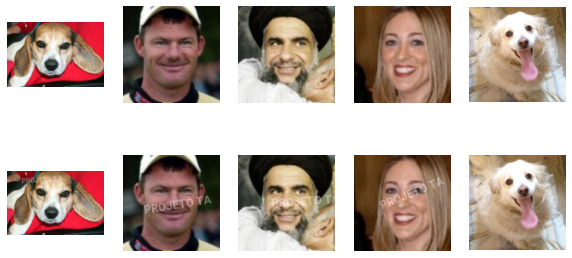


#4 Criar Numpy Arrays das Imagens em "train/original" e "train/watermark"
['person_0598.jpg', 'person_0542.jpg', 'person_0538.jpg', 'person_0616.jpg', 'person_0761.jpg', 'person_0666.jpg', 'person_0353.jpg', 'person_0109.jpg', 'person_0395.jpg', 'person_0193.jpg', 'person_0701.jpg', 'person_0431.jpg', 'person_0816.jpg', 'person_0805.jpg', 'person_0488.jpg', 'person_0358.jpg', 'person_0643.jpg', 'person_0309.jpg', 'person_0379.jpg', 'person_0165.jpg', 'person_0396.jpg', 'person_0654.jpg', 'person_0103.jpg', 'person_0040.jpg', 'person_0156.jpg', 'person_0672.jpg', 'person_0878.jpg', 'person_0279.jpg', 'person_0460.jpg', 'person_0058.jpg', 'person_0406.jpg', 'person_0397.jpg', 'person_0662.jpg', 'person_0136.jpg', 'person_0704.jpg', 'person_0946.jpg', 'person_0094.jpg', 'person_0092.jpg', 'person_0169.jpg', 'person_0733.jpg', 'person_0037.jpg', 'person_0814.jpg', 'person_0793.jpg', 'person_0405.jpg', 'person_0171.jpg', 'person_0952.jpg', 'person_0296.jpg', 'person_0828.jpg', 'person_0176

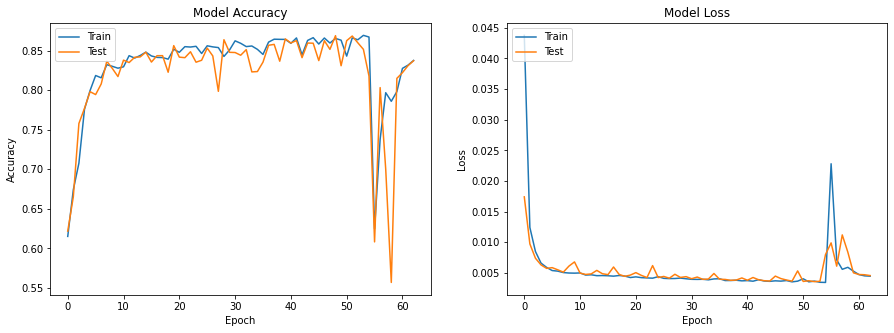

In [ ]:
# 1. Criar as Pastas Necessárias
create_folder_train_test()
# 2. Copiar as várias Imagens para as Pastas
fill_folder_train(0.75)
# 3. Sample de algumas dessas Imagens
images_samples()
# 4. Criar os Numpy Array das Imagens Originais e com Marca de Água
watermark_train_array, original_train_array = image_numpy_array()
# 5. Fazer o Split do Dataset de Treino
train_watermark, validation_watermark, train_original, validation_original = split_dataset(watermark_train_array, original_train_array)
# 6. Criar o Autoencoder
my_autoencoder = autoencoder()
# 7. Compilar o Autoencoder
config_autoencoder(my_autoencoder)
# 8. Treinar o Autoencoder
train_autoencoder(my_autoencoder, train_watermark, validation_watermark, train_original, validation_original)
# 9. Lista de Imagens usadas para este teste
images_dataset = os.listdir(PATH_TRAIN_ORIGINAL)

In [ ]:
# Copiar 5 Imagens Aleatórias para a Pasta de Teste
copy_images_dataset_test(random.sample(os.listdir(PATH_TRAIN_WATERMARK), 5))

In [ ]:
selected_photos =  os.listdir(PATH_TRAIN_TEST)

# Número de Images Total de cada Sub Pasta
images_person = os.listdir(PATH_TRAIN_ORIGINAL)

total_images_person = 0
total_images_dog = 0
total_images_cat = 0
total_images_flower = 0

for image in images_person: 
    # Check if the word is already in dictionary 
    if "person" in image:
      total_images_person += 1
    elif "dog" in image:
      total_images_dog += 1
    elif "cat" in image:
      total_images_cat += 1
    else:
      total_images_flower += 1

# Exibir essas Imagens
figure, ax = plt.subplots(5, 3, figsize=(40, 40))
for index, image_name in enumerate(selected_photos):

    # Abrir Imagem Original
    image_original = load_img(PATH_TRAIN_ORIGINAL + image_name, target_size=(252,252))
    image_original = img_to_array(image_original)

    # Abrir Imagem Watermark
    image_watermark = load_img(PATH_TRAIN_WATERMARK + image_name, target_size=(252,252))
    image_watermark = img_to_array(image_watermark)

    # Abrir Imagem Teste
    image_test = load_img(PATH_TRAIN_TEST + image_name, target_size=(252,252))
    image_test = img_to_array(image_test)
    image_test_img = image_test.astype('float32')/255.
    image_test_img = np.expand_dims(image_test, axis=0)

    # Fazer o Predict
    predict_img = np.squeeze(my_autoencoder.predict(image_test_img))

    # Criar a Disposição das Várias Imagens
    ax[index, 0].imshow(np.squeeze(image_original.astype('uint8')))
    ax[index, 0].set_title('Imagem Original', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 0].axis('off')

    ax[index, 1].imshow(np.squeeze(image_watermark.astype('uint8')))
    ax[index, 1].set_title('Imagem Watermark', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 1].axis('off')

    ax[index, 2].imshow(np.squeeze(predict_img.astype('uint8')))
    ax[index, 2].set_title('Dataset com ' + str(len(images_person)) + ' Imagens' + '\nperson: ' + str(total_images_person) + ', dog: ' + str(total_images_dog) + ', cat:  ' + str(total_images_cat) + ' e flower: ' + str(total_images_flower), fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 2].axis('off')

plt.show()
figure.savefig('/content/drive/My Drive/Colab Notebooks/multipleFoldersFixed.png')

Output hidden; open in https://colab.research.google.com to view.

### Pasta *person*, *flower*, *dog* e *cat* com uma *Watermark* Aleatória

#1 Criar Pastas de Treino "train/original", "train/watermark" e "test"
Pasta "original" já existe. A eliminar a pasta...
Pasta "watermark" já existe. A eliminar a pasta...
Pasta "test" já existe. A eliminar a pasta...

#2 Copiar as Imagens para as Pastas de Treino "train/original" e "train/watermark"
Sub Pasta: person
Número Images Total em person:  986
Número Images Selecionadas de person:  740


Sub Pasta: flower
Número Images Total em flower:  843
Número Images Selecionadas de flower:  632


Sub Pasta: dog
Número Images Total em dog:  702
Número Images Selecionadas de dog:  526


Sub Pasta: cat
Número Images Total em cat:  885
Número Images Selecionadas de cat:  664


Numero de Imagens Total do Dataset Inicial: 885
Numero de Imagens Total do Dataset Selecionado: 664

#3 Samples de Imagens Aleatórias (Original/Watermark)


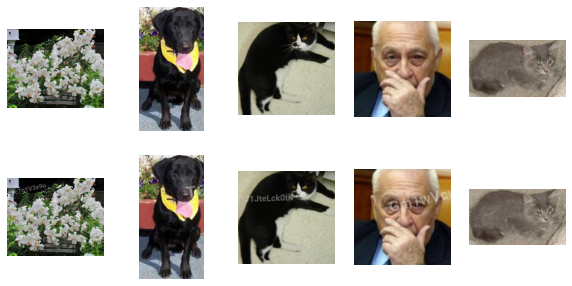


#4 Criar Numpy Arrays das Imagens em "train/original" e "train/watermark"
['person_0613.jpg', 'person_0367.jpg', 'person_0930.jpg', 'person_0803.jpg', 'person_0149.jpg', 'person_0341.jpg', 'person_0069.jpg', 'person_0271.jpg', 'person_0417.jpg', 'person_0901.jpg', 'person_0347.jpg', 'person_0011.jpg', 'person_0200.jpg', 'person_0202.jpg', 'person_0462.jpg', 'person_0770.jpg', 'person_0435.jpg', 'person_0177.jpg', 'person_0787.jpg', 'person_0099.jpg', 'person_0679.jpg', 'person_0415.jpg', 'person_0283.jpg', 'person_0374.jpg', 'person_0215.jpg', 'person_0737.jpg', 'person_0895.jpg', 'person_0484.jpg', 'person_0461.jpg', 'person_0923.jpg', 'person_0963.jpg', 'person_0465.jpg', 'person_0456.jpg', 'person_0122.jpg', 'person_0346.jpg', 'person_0504.jpg', 'person_0212.jpg', 'person_0911.jpg', 'person_0688.jpg', 'person_0544.jpg', 'person_0413.jpg', 'person_0105.jpg', 'person_0823.jpg', 'person_0216.jpg', 'person_0188.jpg', 'person_0978.jpg', 'person_0953.jpg', 'person_0418.jpg', 'person_0721

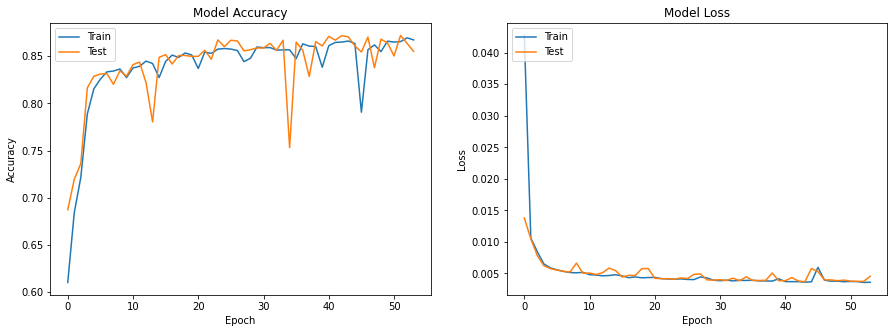

In [ ]:
# 1. Criar as Pastas Necessárias
create_folder_train_test()
# 2. Copiar as várias Imagens para as Pastas
fill_folder_train(0.75, None, 1)
# 3. Sample de algumas dessas Imagens
images_samples()
# 4. Criar os Numpy Array das Imagens Originais e com Marca de Água
watermark_train_array, original_train_array = image_numpy_array()
# 5. Fazer o Split do Dataset de Treino
train_watermark, validation_watermark, train_original, validation_original = split_dataset(watermark_train_array, original_train_array)
# 6. Criar o Autoencoder
my_autoencoder = autoencoder()
# 7. Compilar o Autoencoder
config_autoencoder(my_autoencoder)
# 8. Treinar o Autoencoder
train_autoencoder(my_autoencoder, train_watermark, validation_watermark, train_original, validation_original)
# 9. Lista de Imagens usadas para este teste
images_dataset = os.listdir(PATH_TRAIN_ORIGINAL)

In [ ]:
# Copiar 5 Imagens Aleatórias para a Pasta de Teste
copy_images_dataset_test(random.sample(os.listdir(PATH_TRAIN_WATERMARK), 5))

In [ ]:
selected_photos =  os.listdir(PATH_TRAIN_TEST)

# Número de Images Total de cada Sub Pasta
images_person = os.listdir(PATH_TRAIN_ORIGINAL)

total_images_person = 0
total_images_dog = 0
total_images_cat = 0
total_images_flower = 0

for image in images_person: 
    # Check if the word is already in dictionary 
    if "person" in image:
      total_images_person += 1
    elif "dog" in image:
      total_images_dog += 1
    elif "cat" in image:
      total_images_cat += 1
    else:
      total_images_flower += 1

# Exibir essas Imagens
figure, ax = plt.subplots(5, 3, figsize=(40, 40))
for index, image_name in enumerate(selected_photos):

    # Abrir Imagem Original
    image_original = load_img(PATH_TRAIN_ORIGINAL + image_name, target_size=(252,252))
    image_original = img_to_array(image_original)

    # Abrir Imagem Watermark
    image_watermark = load_img(PATH_TRAIN_WATERMARK + image_name, target_size=(252,252))
    image_watermark = img_to_array(image_watermark)

    # Abrir Imagem Teste
    image_test = load_img(PATH_TRAIN_TEST + image_name, target_size=(252,252))
    image_test = img_to_array(image_test)
    image_test_img = image_test.astype('float32')/255.
    image_test_img = np.expand_dims(image_test, axis=0)

    # Fazer o Predict
    predict_img = np.squeeze(my_autoencoder.predict(image_test_img))

    # Criar a Disposição das Várias Imagens
    ax[index, 0].imshow(np.squeeze(image_original.astype('uint8')))
    ax[index, 0].set_title('Imagem Original', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 0].axis('off')

    ax[index, 1].imshow(np.squeeze(image_watermark.astype('uint8')))
    ax[index, 1].set_title('Imagem Watermark', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 1].axis('off')

    ax[index, 2].imshow(np.squeeze(predict_img.astype('uint8')))
    ax[index, 2].set_title('Dataset com ' + str(len(images_person)) + ' Imagens' + '\nperson: ' + str(total_images_person) + ', dog: ' + str(total_images_dog) + ', cat:  ' + str(total_images_cat) + ' e flower: ' + str(total_images_flower), fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 2].axis('off')

plt.show()
figure.savefig('/content/drive/My Drive/Colab Notebooks/multipleFoldersRandom.png')

Output hidden; open in https://colab.research.google.com to view.

### Pasta *person* com 100%, 60% e 30% do *Dataset* com uma *Watermark* Fixa

#1 Criar Pastas de Treino "train/original", "train/watermark" e "test"
Pasta "original" já existe. A eliminar a pasta...
Pasta "watermark" já existe. A eliminar a pasta...
Pasta "test" já existe. A eliminar a pasta...

#2 Copiar as Imagens para as Pastas de Treino "train/original" e "train/watermark"
Sub Pasta: person
Número Images Total em person:  986
Número Images Selecionadas de person:  986


Numero de Imagens Total do Dataset Inicial: 986
Numero de Imagens Total do Dataset Selecionado: 986

#3 Samples de Imagens Aleatórias (Original/Watermark)


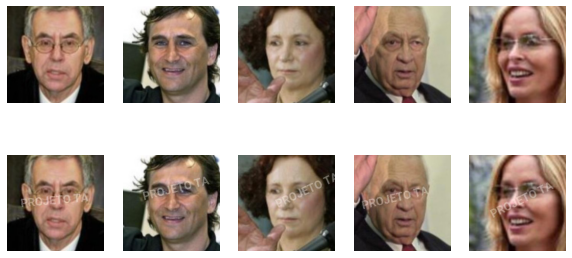


#4 Criar Numpy Arrays das Imagens em "train/original" e "train/watermark"
['person_0880.jpg', 'person_0787.jpg', 'person_0450.jpg', 'person_0056.jpg', 'person_0586.jpg', 'person_0312.jpg', 'person_0422.jpg', 'person_0353.jpg', 'person_0075.jpg', 'person_0295.jpg', 'person_0198.jpg', 'person_0280.jpg', 'person_0486.jpg', 'person_0667.jpg', 'person_0217.jpg', 'person_0065.jpg', 'person_0278.jpg', 'person_0544.jpg', 'person_0957.jpg', 'person_0739.jpg', 'person_0272.jpg', 'person_0374.jpg', 'person_0736.jpg', 'person_0842.jpg', 'person_0550.jpg', 'person_0696.jpg', 'person_0756.jpg', 'person_0006.jpg', 'person_0482.jpg', 'person_0227.jpg', 'person_0266.jpg', 'person_0047.jpg', 'person_0748.jpg', 'person_0264.jpg', 'person_0333.jpg', 'person_0525.jpg', 'person_0326.jpg', 'person_0467.jpg', 'person_0778.jpg', 'person_0929.jpg', 'person_0956.jpg', 'person_0315.jpg', 'person_0328.jpg', 'person_0189.jpg', 'person_0313.jpg', 'person_0816.jpg', 'person_0975.jpg', 'person_0644.jpg', 'person_0881

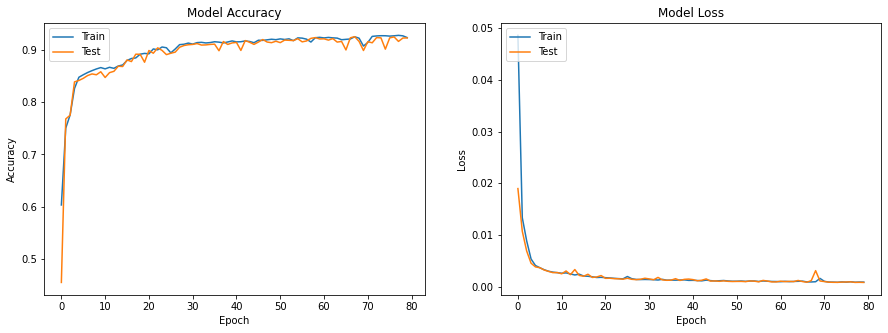

In [ ]:
################### Para 100% do Dataset ###################

# 1. Criar as Pastas Necessárias
create_folder_train_test()
# 2. Copiar as várias Imagens para as Pastas
fill_folder_train(1, 'person')
# 3. Sample de algumas dessas Imagens
images_samples()
# 4. Criar os Numpy Array das Imagens Originais e com Marca de Água
watermark_train_array_100, original_train_array_100 = image_numpy_array()
# 5. Fazer o Split do Dataset de Treino
train_watermark_100, validation_watermark_100, train_original_100, validation_original_100 = split_dataset(watermark_train_array_100, original_train_array_100)
# 6. Criar o Autoencoder
autoencoder_100 = autoencoder()
# 7. Compilar o Autoencoder
config_autoencoder(autoencoder_100)
# 8. Treinar o Autoencoder
train_autoencoder(autoencoder_100, train_watermark_100, validation_watermark_100, train_original_100, validation_original_100)
# 9. Lista de Imagens usadas para este teste
images_dataset_100 = os.listdir(PATH_TRAIN_ORIGINAL)

#1 Criar Pastas de Treino "train/original", "train/watermark" e "test"
Pasta "original" já existe. A eliminar a pasta...
Pasta "watermark" já existe. A eliminar a pasta...
Pasta "test" já existe. A eliminar a pasta...

#2 Copiar as Imagens para as Pastas de Treino "train/original" e "train/watermark"
Sub Pasta: person
Número Images Total em person:  986
Número Images Selecionadas de person:  592


Numero de Imagens Total do Dataset Inicial: 986
Numero de Imagens Total do Dataset Selecionado: 592

#3 Samples de Imagens Aleatórias (Original/Watermark)


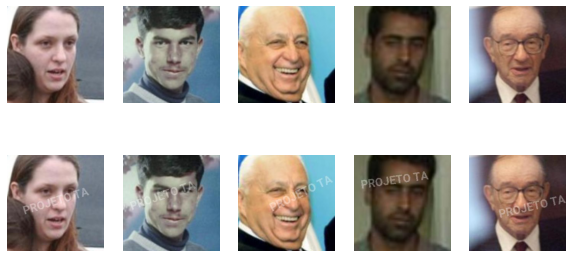


#4 Criar Numpy Arrays das Imagens em "train/original" e "train/watermark"
['person_0526.jpg', 'person_0822.jpg', 'person_0842.jpg', 'person_0686.jpg', 'person_0071.jpg', 'person_0985.jpg', 'person_0261.jpg', 'person_0515.jpg', 'person_0428.jpg', 'person_0646.jpg', 'person_0407.jpg', 'person_0317.jpg', 'person_0668.jpg', 'person_0881.jpg', 'person_0273.jpg', 'person_0582.jpg', 'person_0786.jpg', 'person_0522.jpg', 'person_0106.jpg', 'person_0079.jpg', 'person_0177.jpg', 'person_0899.jpg', 'person_0788.jpg', 'person_0277.jpg', 'person_0081.jpg', 'person_0033.jpg', 'person_0442.jpg', 'person_0527.jpg', 'person_0167.jpg', 'person_0014.jpg', 'person_0578.jpg', 'person_0150.jpg', 'person_0330.jpg', 'person_0897.jpg', 'person_0112.jpg', 'person_0666.jpg', 'person_0220.jpg', 'person_0600.jpg', 'person_0288.jpg', 'person_0248.jpg', 'person_0605.jpg', 'person_0966.jpg', 'person_0159.jpg', 'person_0716.jpg', 'person_0580.jpg', 'person_0019.jpg', 'person_0025.jpg', 'person_0157.jpg', 'person_0670

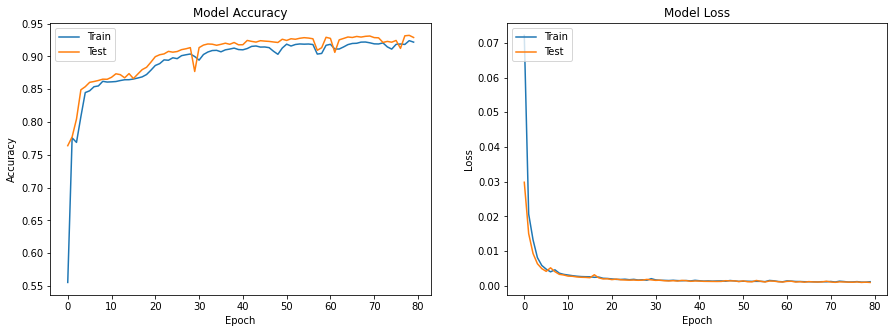

In [ ]:
################### Para 60% do Dataset ###################

# 1. Criar as Pastas Necessárias
create_folder_train_test()
# 2. Copiar as várias Imagens para as Pastas
fill_folder_train(0.60, 'person')
# 3. Sample de algumas dessas Imagens
images_samples()
# 4. Criar os Numpy Array das Imagens Originais e com Marca de Àgua
watermark_train_array_60, original_train_array_60 = image_numpy_array()
# 5. Fazer o Split do Dataset de Treino
train_watermark_60, validation_watermark_60, train_original_60, validation_original_60 = split_dataset(watermark_train_array_60, original_train_array_60)
# 6. Criar o Autoencoder
autoencoder_60 = autoencoder()
# 7. Compilar o Autoencoder
config_autoencoder(autoencoder_60)
# 8. Treinar o Autoencoder
train_autoencoder(autoencoder_60, train_watermark_60, validation_watermark_60, train_original_60, validation_original_60)
# 9. Lista de Imagens usadas para este teste
images_dataset_60 = os.listdir(PATH_TRAIN_ORIGINAL)

#1 Criar Pastas de Treino "train/original", "train/watermark" e "test"
Pasta "original" já existe. A eliminar a pasta...
Pasta "watermark" já existe. A eliminar a pasta...
Pasta "test" já existe. A eliminar a pasta...

#2 Copiar as Imagens para as Pastas de Treino "train/original" e "train/watermark"
Sub Pasta: person
Número Images Total em person:  986
Número Images Selecionadas de person:  296


Numero de Imagens Total do Dataset Inicial: 986
Numero de Imagens Total do Dataset Selecionado: 296

#3 Samples de Imagens Aleatórias (Original/Watermark)


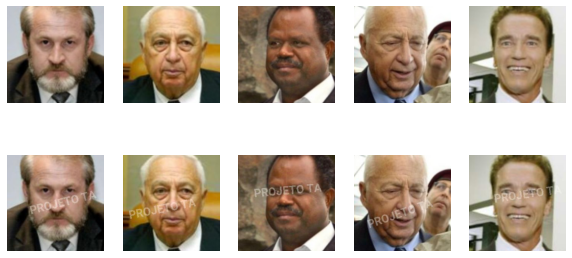


#4 Criar Numpy Arrays das Imagens em "train/original" e "train/watermark"
['person_0282.jpg', 'person_0985.jpg', 'person_0402.jpg', 'person_0018.jpg', 'person_0908.jpg', 'person_0240.jpg', 'person_0620.jpg', 'person_0628.jpg', 'person_0788.jpg', 'person_0048.jpg', 'person_0330.jpg', 'person_0116.jpg', 'person_0933.jpg', 'person_0610.jpg', 'person_0694.jpg', 'person_0393.jpg', 'person_0092.jpg', 'person_0279.jpg', 'person_0336.jpg', 'person_0024.jpg', 'person_0487.jpg', 'person_0118.jpg', 'person_0568.jpg', 'person_0264.jpg', 'person_0542.jpg', 'person_0436.jpg', 'person_0397.jpg', 'person_0823.jpg', 'person_0170.jpg', 'person_0817.jpg', 'person_0273.jpg', 'person_0275.jpg', 'person_0976.jpg', 'person_0839.jpg', 'person_0643.jpg', 'person_0756.jpg', 'person_0510.jpg', 'person_0313.jpg', 'person_0119.jpg', 'person_0820.jpg', 'person_0580.jpg', 'person_0174.jpg', 'person_0615.jpg', 'person_0258.jpg', 'person_0871.jpg', 'person_0701.jpg', 'person_0776.jpg', 'person_0537.jpg', 'person_0960

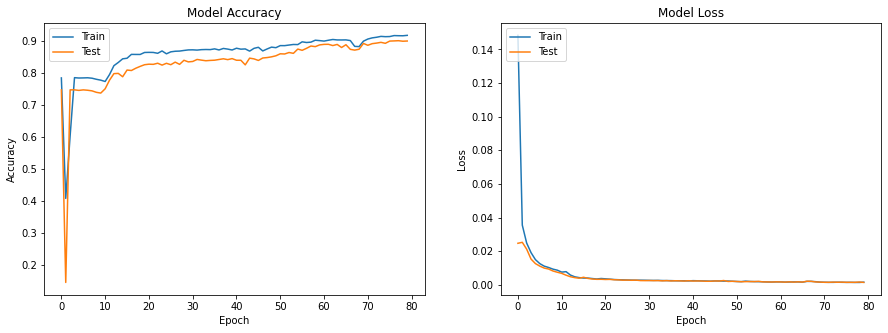

In [ ]:
################### Para 30% do Dataset ###################

# 1. Criar as Pastas Necessárias
create_folder_train_test()
# 2. Copiar as várias Imagens para as Pastas
fill_folder_train(0.30, 'person')
# 3. Sample de algumas dessas Imagens
images_samples()
# 4. Criar os Numpy Array das Imagens Originais e com Marca de Àgua
watermark_train_array_30, original_train_array_30 = image_numpy_array()
# 5. Fazer o Split do Dataset de Treino
train_watermark_30, validation_watermark_30, train_original_30, validation_original_30 = split_dataset(watermark_train_array_30, original_train_array_30)
# 6. Criar o Autoencoder
autoencoder_30 = autoencoder()
# 7. Compilar o Autoencoder
config_autoencoder(autoencoder_30)
# 8. Treinar o Autoencoder
train_autoencoder(autoencoder_30, train_watermark_30, validation_watermark_30, train_original_30, validation_original_30)
# 9. Lista de Imagens usadas para este teste
images_dataset_30 = os.listdir(PATH_TRAIN_ORIGINAL)

In [ ]:
# Obter Imagens Comuns entre os 3 testes feitos
common_images = list(set(images_dataset_100).intersection(images_dataset_60).intersection(images_dataset_30))

# Copiar 5 dessas Imagens para a Pasta de Teste
copy_images_dataset_test(random.sample(common_images, 5))

In [ ]:
selected_photos =  os.listdir(PATH_TRAIN_TEST)

# Exibir essas Imagens
figure, ax = plt.subplots(5, 5, figsize=(40, 40))
for index, image_name in enumerate(selected_photos):

    # Abrir Imagem Original
    image_original = load_img(PATH_TRAIN_ORIGINAL + image_name, target_size=(252,252))
    image_original = img_to_array(image_original)

    # Abrir Imagem Watermark
    image_watermark = load_img(PATH_TRAIN_WATERMARK + image_name, target_size=(252,252))
    image_watermark = img_to_array(image_watermark)

    # Abrir Imagem Teste
    image_test = load_img(PATH_TRAIN_TEST + image_name, target_size=(252,252))
    image_test = img_to_array(image_test)
    image_test_img = image_test.astype('float32')/255.
    image_test_img = np.expand_dims(image_test, axis=0)

    # Fazer o Predict
    predict_img_100 = np.squeeze(autoencoder_100.predict(image_test_img))
    predict_img_60 = np.squeeze(autoencoder_60.predict(image_test_img))
    predict_img_30 = np.squeeze(autoencoder_30.predict(image_test_img))

    # Criar a Disposição das Várias Imagens
    ax[index, 0].imshow(np.squeeze(image_original.astype('uint8')))
    ax[index, 0].set_title('Imagem Original', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 0].axis('off')

    ax[index, 1].imshow(np.squeeze(image_watermark.astype('uint8')))
    ax[index, 1].set_title('Imagem Watermark', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 1].axis('off')

    ax[index, 2].imshow(np.squeeze(predict_img_100.astype('uint8')))
    ax[index, 2].set_title('Dataset com ' + str(len(images_dataset_100)) + ' imagens', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 2].axis('off')

    ax[index, 3].imshow(np.squeeze(predict_img_60.astype('uint8')))
    ax[index, 3].set_title('Dataset com ' + str(len(images_dataset_60)) + ' imagens', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 3].axis('off')

    ax[index, 4].imshow(np.squeeze(predict_img_30.astype('uint8')))
    ax[index, 4].set_title('Dataset com ' + str(len(images_dataset_30)) + ' imagens', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 4].axis('off')

plt.show()
figure.savefig('/content/drive/My Drive/Colab Notebooks/personFolderFixed.png')

Output hidden; open in https://colab.research.google.com to view.

### Pasta *person* com 100%, 60% e 30% do *Dataset* com uma Watermark Aleatória

#1 Criar Pastas de Treino "train/original", "train/watermark" e "test"
Pasta "original" já existe. A eliminar a pasta...
Pasta "watermark" já existe. A eliminar a pasta...
Pasta "test" já existe. A eliminar a pasta...

#2 Copiar as Imagens para as Pastas de Treino "train/original" e "train/watermark"
Sub Pasta: person
Número Images Total em person:  986
Número Images Selecionadas de person:  986


Numero de Imagens Total do Dataset Inicial: 986
Numero de Imagens Total do Dataset Selecionado: 986

#3 Samples de Imagens Aleatórias (Original/Watermark)


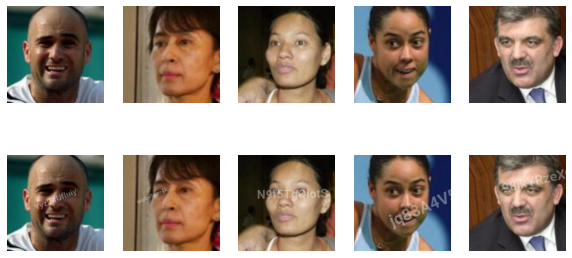


#4 Criar Numpy Arrays das Imagens em "train/original" e "train/watermark"
['person_0796.jpg', 'person_0360.jpg', 'person_0132.jpg', 'person_0923.jpg', 'person_0533.jpg', 'person_0609.jpg', 'person_0955.jpg', 'person_0934.jpg', 'person_0828.jpg', 'person_0057.jpg', 'person_0774.jpg', 'person_0189.jpg', 'person_0887.jpg', 'person_0659.jpg', 'person_0773.jpg', 'person_0039.jpg', 'person_0392.jpg', 'person_0033.jpg', 'person_0170.jpg', 'person_0049.jpg', 'person_0572.jpg', 'person_0845.jpg', 'person_0413.jpg', 'person_0074.jpg', 'person_0487.jpg', 'person_0704.jpg', 'person_0455.jpg', 'person_0620.jpg', 'person_0601.jpg', 'person_0165.jpg', 'person_0430.jpg', 'person_0688.jpg', 'person_0356.jpg', 'person_0414.jpg', 'person_0723.jpg', 'person_0504.jpg', 'person_0002.jpg', 'person_0797.jpg', 'person_0345.jpg', 'person_0214.jpg', 'person_0426.jpg', 'person_0807.jpg', 'person_0813.jpg', 'person_0022.jpg', 'person_0593.jpg', 'person_0548.jpg', 'person_0381.jpg', 'person_0752.jpg', 'person_0272

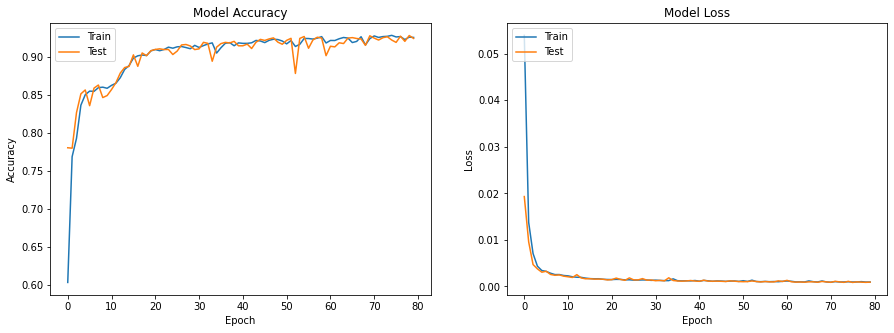

In [ ]:
################### Para 100% do Dataset ###################

# 1. Criar as Pastas Necessárias
create_folder_train_test()
# 2. Copiar as várias Imagens para as Pastas
fill_folder_train(1, 'person', 1)
# 3. Sample de algumas dessas Imagens
images_samples()
# 4. Criar os Numpy Array das Imagens Originais e com Marca de Água
watermark_train_array_100, original_train_array_100 = image_numpy_array()
# 5. Fazer o Split do Dataset de Treino
train_watermark_100, validation_watermark_100, train_original_100, validation_original_100 = split_dataset(watermark_train_array_100, original_train_array_100)
# 6. Criar o Autoencoder
autoencoder_100 = autoencoder()
# 7. Compilar o Autoencoder
config_autoencoder(autoencoder_100)
# 8. Treinar o Autoencoder
train_autoencoder(autoencoder_100, train_watermark_100, validation_watermark_100, train_original_100, validation_original_100)
# 9. Lista de Imagens usadas para este teste
images_dataset_100 = os.listdir(PATH_TRAIN_ORIGINAL)

#1 Criar Pastas de Treino "train/original", "train/watermark" e "test"
Pasta "original" já existe. A eliminar a pasta...
Pasta "watermark" já existe. A eliminar a pasta...
Pasta "test" já existe. A eliminar a pasta...

#2 Copiar as Imagens para as Pastas de Treino "train/original" e "train/watermark"
Sub Pasta: person
Número Images Total em person:  986
Número Images Selecionadas de person:  592


Numero de Imagens Total do Dataset Inicial: 986
Numero de Imagens Total do Dataset Selecionado: 592

#3 Samples de Imagens Aleatórias (Original/Watermark)


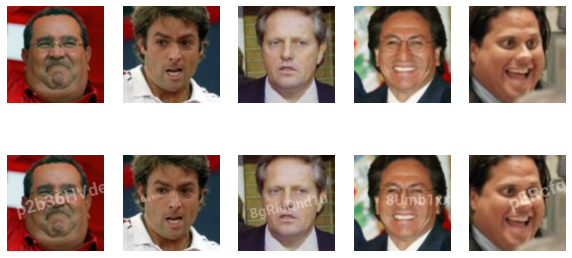


#4 Criar Numpy Arrays das Imagens em "train/original" e "train/watermark"
['person_0138.jpg', 'person_0615.jpg', 'person_0906.jpg', 'person_0602.jpg', 'person_0841.jpg', 'person_0179.jpg', 'person_0068.jpg', 'person_0616.jpg', 'person_0798.jpg', 'person_0148.jpg', 'person_0661.jpg', 'person_0305.jpg', 'person_0909.jpg', 'person_0024.jpg', 'person_0091.jpg', 'person_0778.jpg', 'person_0237.jpg', 'person_0603.jpg', 'person_0650.jpg', 'person_0120.jpg', 'person_0893.jpg', 'person_0444.jpg', 'person_0563.jpg', 'person_0947.jpg', 'person_0358.jpg', 'person_0594.jpg', 'person_0975.jpg', 'person_0074.jpg', 'person_0836.jpg', 'person_0922.jpg', 'person_0410.jpg', 'person_0498.jpg', 'person_0826.jpg', 'person_0440.jpg', 'person_0264.jpg', 'person_0008.jpg', 'person_0419.jpg', 'person_0941.jpg', 'person_0034.jpg', 'person_0139.jpg', 'person_0912.jpg', 'person_0834.jpg', 'person_0163.jpg', 'person_0412.jpg', 'person_0657.jpg', 'person_0954.jpg', 'person_0939.jpg', 'person_0233.jpg', 'person_0931

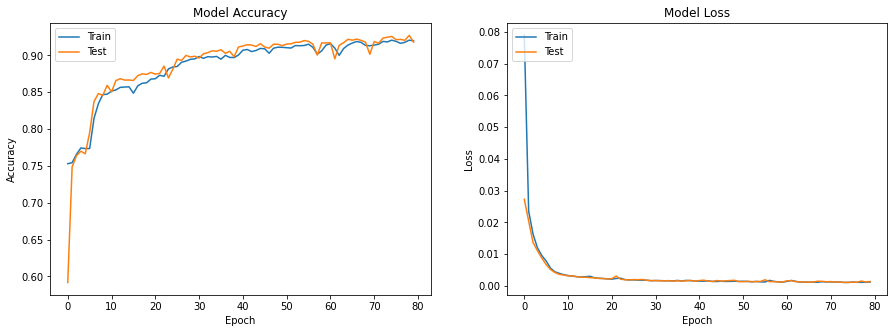

In [ ]:
################### Para 60% do Dataset ###################

# 1. Criar as Pastas Necessárias
create_folder_train_test()
# 2. Copiar as várias Imagens para as Pastas
fill_folder_train(0.60, 'person', 1)
# 3. Sample de algumas dessas Imagens
images_samples()
# 4. Criar os Numpy Array das Imagens Originais e com Marca de Àgua
watermark_train_array_60, original_train_array_60 = image_numpy_array()
# 5. Fazer o Split do Dataset de Treino
train_watermark_60, validation_watermark_60, train_original_60, validation_original_60 = split_dataset(watermark_train_array_60, original_train_array_60)
# 6. Criar o Autoencoder
autoencoder_60 = autoencoder()
# 7. Compilar o Autoencoder
config_autoencoder(autoencoder_60)
# 8. Treinar o Autoencoder
train_autoencoder(autoencoder_60, train_watermark_60, validation_watermark_60, train_original_60, validation_original_60)
# 9. Lista de Imagens usadas para este teste
images_dataset_60 = os.listdir(PATH_TRAIN_ORIGINAL)

#1 Criar Pastas de Treino "train/original", "train/watermark" e "test"
Pasta "original" já existe. A eliminar a pasta...
Pasta "watermark" já existe. A eliminar a pasta...
Pasta "test" já existe. A eliminar a pasta...

#2 Copiar as Imagens para as Pastas de Treino "train/original" e "train/watermark"
Sub Pasta: person
Número Images Total em person:  986
Número Images Selecionadas de person:  296


Numero de Imagens Total do Dataset Inicial: 986
Numero de Imagens Total do Dataset Selecionado: 296

#3 Samples de Imagens Aleatórias (Original/Watermark)


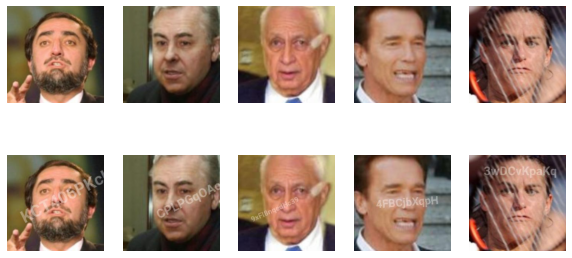


#4 Criar Numpy Arrays das Imagens em "train/original" e "train/watermark"
['person_0000.jpg', 'person_0108.jpg', 'person_0130.jpg', 'person_0094.jpg', 'person_0224.jpg', 'person_0969.jpg', 'person_0397.jpg', 'person_0145.jpg', 'person_0120.jpg', 'person_0265.jpg', 'person_0378.jpg', 'person_0024.jpg', 'person_0227.jpg', 'person_0744.jpg', 'person_0692.jpg', 'person_0657.jpg', 'person_0689.jpg', 'person_0619.jpg', 'person_0661.jpg', 'person_0526.jpg', 'person_0532.jpg', 'person_0754.jpg', 'person_0295.jpg', 'person_0298.jpg', 'person_0258.jpg', 'person_0387.jpg', 'person_0432.jpg', 'person_0299.jpg', 'person_0346.jpg', 'person_0603.jpg', 'person_0006.jpg', 'person_0312.jpg', 'person_0839.jpg', 'person_0233.jpg', 'person_0267.jpg', 'person_0662.jpg', 'person_0819.jpg', 'person_0696.jpg', 'person_0937.jpg', 'person_0386.jpg', 'person_0755.jpg', 'person_0045.jpg', 'person_0292.jpg', 'person_0456.jpg', 'person_0756.jpg', 'person_0225.jpg', 'person_0801.jpg', 'person_0357.jpg', 'person_0590

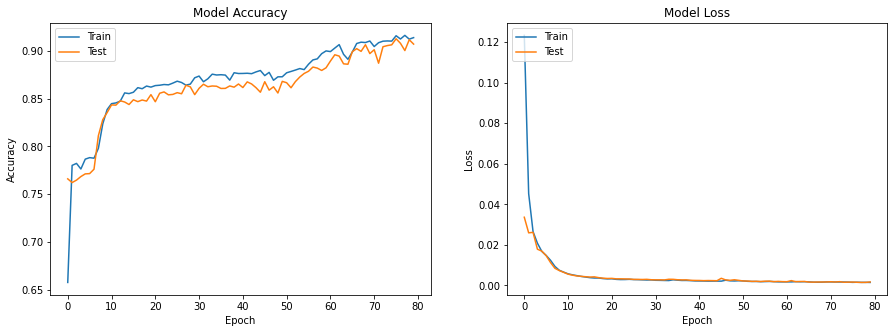

In [ ]:
################### Para 30% do Dataset ###################

# 1. Criar as Pastas Necessárias
create_folder_train_test()
# 2. Copiar as várias Imagens para as Pastas
fill_folder_train(0.30, 'person', 1)
# 3. Sample de algumas dessas Imagens
images_samples()
# 4. Criar os Numpy Array das Imagens Originais e com Marca de Àgua
watermark_train_array_30, original_train_array_30 = image_numpy_array()
# 5. Fazer o Split do Dataset de Treino
train_watermark_30, validation_watermark_30, train_original_30, validation_original_30 = split_dataset(watermark_train_array_30, original_train_array_30)
# 6. Criar o Autoencoder
autoencoder_30 = autoencoder()
# 7. Compilar o Autoencoder
config_autoencoder(autoencoder_30)
# 8. Treinar o Autoencoder
train_autoencoder(autoencoder_30, train_watermark_30, validation_watermark_30, train_original_30, validation_original_30)
# 9. Lista de Imagens usadas para este teste
images_dataset_30 = os.listdir(PATH_TRAIN_ORIGINAL)

In [ ]:
# Obter Imagens Comuns entre os 3 testes feitos
common_images = list(set(images_dataset_100).intersection(images_dataset_60).intersection(images_dataset_30))

# Copiar 5 dessas Imagens para a Pasta de Teste
copy_images_dataset_test(random.sample(common_images, 5))

In [ ]:
selected_photos =  os.listdir(PATH_TRAIN_TEST)

# Exibir essas Imagens
figure, ax = plt.subplots(5, 5, figsize=(40, 40))
for index, image_name in enumerate(selected_photos):

    # Abrir Imagem Original
    image_original = load_img(PATH_TRAIN_ORIGINAL + image_name, target_size=(252,252))
    image_original = img_to_array(image_original)

    # Abrir Imagem Watermark
    image_watermark = load_img(PATH_TRAIN_WATERMARK + image_name, target_size=(252,252))
    image_watermark = img_to_array(image_watermark)

    # Abrir Imagem Teste
    image_test = load_img(PATH_TRAIN_TEST + image_name, target_size=(252,252))
    image_test = img_to_array(image_test)
    image_test_img = image_test.astype('float32')/255.
    image_test_img = np.expand_dims(image_test, axis=0)

    # Fazer o Predict
    predict_img_100 = np.squeeze(autoencoder_100.predict(image_test_img))
    predict_img_60 = np.squeeze(autoencoder_60.predict(image_test_img))
    predict_img_30 = np.squeeze(autoencoder_30.predict(image_test_img))

    # Criar a Disposição das Várias Imagens
    ax[index, 0].imshow(np.squeeze(image_original.astype('uint8')))
    ax[index, 0].set_title('Imagem Original', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 0].axis('off')

    ax[index, 1].imshow(np.squeeze(image_watermark.astype('uint8')))
    ax[index, 1].set_title('Imagem Watermark', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 1].axis('off')

    ax[index, 2].imshow(np.squeeze(predict_img_100.astype('uint8')))
    ax[index, 2].set_title('Dataset com ' + str(len(images_dataset_100)) + ' imagens', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 2].axis('off')

    ax[index, 3].imshow(np.squeeze(predict_img_60.astype('uint8')))
    ax[index, 3].set_title('Dataset com ' + str(len(images_dataset_60)) + ' imagens', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 3].axis('off')

    ax[index, 4].imshow(np.squeeze(predict_img_30.astype('uint8')))
    ax[index, 4].set_title('Dataset com ' + str(len(images_dataset_30)) + ' imagens', fontdict={'fontsize': 30, 'fontweight': 'medium'})
    ax[index, 4].axis('off')

plt.show()
figure.savefig('/content/drive/My Drive/Colab Notebooks/personFolderRandom.png')

Output hidden; open in https://colab.research.google.com to view.

## **Análise Resultados Obtidos**

**Para se conseguir obter uma Análise dos Resultados Obtidos, a ideia passou por efetuar um conjunto de testes que prioriza:**

1.   Os diferentes tamanhos para o *dataset* de treino
2.   A quantidade de classes de Imagens distintas
3.   A aleatoriedade da *watermark* usada

Dessa forma, consegue-se um conjunto de resultados sólido o suficiente para compreender aquilo que realmente influencia nos valores de *accuracy* e que depois são visíveis nas previsões feitas pelo modelo do *Autoencoder* criado.


### Análise dos Valores *Accuracy* e *Loss*

**Depois de correr todos os testes e com todos os *plots* prontos a ser interpretados, cria-se uma tabela que permite estabelecer uma correspondência entre todos os valores dos vários testes produzidos:**

<br/>

| Nome/Tipo Teste                                              |*Train Accuracy* | *Train Loss* |*Validation Accuracy* |*Validation Loss* | Nota                                               |
| ------------------------------------------------------------ | ---------------------- | --------------------- | --------------------------- | -------------------------- | -------------------------------------------------- |
| Pasta *person*, *flower*, *dog* e *cat* <br>*Watermark* Fixa | 0.8375 ≈ 83%           | 0.0045 ≈ 0%           | 0.8371≈ 83%                 | 0.0046 ≈ 0%                | *Early Stopping* <br>63 *Epochs*                   |
| Pasta *person*, *flower*, *dog* e *cat* <br/> *Watermark* Aleatória | 0.8673 ≈ 86%           | 0.0036 ≈ 0%           | 0.8552 ≈ 85%                | 0.0046 ≈ 0%                | *Early Stopping*<br/>54 *Epochs* |
| Pasta *person* com 100%, 60% e 30% do *Dataset*<br/> *Watermark* Fixa | 0.9239 ≈ 92%           | 8.7004e-04 ≈ 0%       | 0.9239 ≈ 92%                | 8.0550e-04 ≈ 0%            | Fez as 80 Epochs                                   |
| Pasta *person* com 100%, 60% e 30% do *Dataset* <br/> Watermark Aleatória | 0.9261 ≈ 93%           | 9.4640e-04 ≈ 0%       | 0.9248 ≈ 93%                | 9.2639e-04 ≈ 0%            | Fez as 80 Epochs                                   |

<br/>

*   Existe realmente uma diferença quando se usam apenas Imagens de pessoas comparativamente à mistura de várias classes/tipos de imagens
*   O valor de *Loss* para o geral dos testes apresenta um valor muito satisfatório
*   Os valores de *Accuracy* são ligeiramente melhores no uso de *Watermark* aleatória para cada Imagem do treino
*   Para os dois testes inicial (onde existiu a mistura de classes de imagens), o *callback* *Early Stopping* foi acionado


### Análise das Imagens Previstas

Estando a Análise dos Valores de *Accuracy* e *Loss* totalmente discriminada, nada melhor que comprovar essas conclusões e perceber o seu impacto em termos visuais.

**Dessa forma, observe-se os *plots* criados que permitem estabelecer uma comparação dos vários resultados:**

<br>

**1. Pasta *person*, *flower*, *dog* e *cat* com uma *Watermark* Fixa**
![](https://drive.google.com/uc?export=view&id=1qRFemileZkj7-cGGWwZbVeEmXBvvL4Q2)

**2. Pasta *person*, *flower*, *dog* e *cat* com uma *Watermark* Aleatória**
![](https://drive.google.com/uc?export=view&id=1SMw3LK93aQW7Jv-KfKswoS9PqW_Ttmkp)

**3. Pasta *person* com 100%, 60% e 30% do *Dataset* com uma *Watermark* Fixa**
![](https://drive.google.com/uc?export=view&id=1542avIvPomiskpMKyCMeR7JhMC97R1Xm)

**4. Pasta *person* com 100%, 60% e 30% do *Dataset* com uma *Watermark* Aleatória**
![](https://drive.google.com/uc?export=view&id=19TWJpT1Krdoe0ysgDqWlueB5HYT-JBek)


## **Referências**

